In [1]:
import os
import tensorflow as tf
import numpy as np
import keras_cv
import cv2
import random
import math
from tensorflow import keras
from matplotlib import pyplot as plt

Using TensorFlow backend


d:\Users\Claudio\anaconda3\envs\carla-test\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tf.version.VERSION

'2.13.0'

In [3]:
def parse_yolov8_annotation(txt_file):
    yolov8_boxes = []
    class_ids = []
    with open(txt_file) as file:
      for line in file:
        splitted_line = line.split()
        class_ids.append(int(splitted_line[0]))
        rcx = float(splitted_line[1])
        rcy = float(splitted_line[2])
        rw = float(splitted_line[3])
        rh = float(splitted_line[4])
        rxmin=rcx-rw/2
        rymin=rcy-rh/2
        yolov8_boxes.append([rxmin, rymin, rw, rh]) #rel_xywh

    return yolov8_boxes, class_ids

def load_dataset_info(txt_file_list,image_path):
  image_path_list = []
  image_yolov8_box_list = []
  image_class_id_list = []
  for txt_file in txt_file_list:
      yolov8_boxes, class_ids = parse_yolov8_annotation(txt_file)
      image_path_list.append(image_path+os.path.basename(os.path.splitext(txt_file)[0])+'.jpg')
      image_yolov8_box_list.append(yolov8_boxes)
      image_class_id_list.append(class_ids)

  return image_path_list,image_yolov8_box_list,image_class_id_list

def from_rel_xywh_to_xywh(dataset_rel_xywh_bboxes,image_shape):
  image_height=image_shape[0]
  image_width=image_shape[1]

  dataset_xywh_bboxes=[]
  for image_bboxes in dataset_rel_xywh_bboxes:
    image_xywh_bboxes=[]
    for image_bbox in image_bboxes:
      xmin=image_bbox[0]*image_width
      ymin=image_bbox[1]*image_height
      w=image_bbox[2]*image_width
      h=image_bbox[3]*image_height
      image_xywh_bboxes.append([xmin, ymin, w, h])
    dataset_xywh_bboxes.append(image_xywh_bboxes)

  return dataset_xywh_bboxes

def load_dataset_element(image_path, bboxes,classes):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    bounding_boxes = {
        'classes': tf.cast(classes, dtype=tf.float32),
        'boxes': bboxes,
    }
    return {'images': tf.cast(image, tf.float32), 'bounding_boxes': bounding_boxes}

def prepare_dataset(dataset,batch_size,model_input_size):
  resizer = keras.Sequential(layers=[keras_cv.layers.Resizing(model_input_size,model_input_size,pad_to_aspect_ratio=True,bounding_box_format='xywh')])

  ds = dataset.map(load_dataset_element, num_parallel_calls=tf.data.AUTOTUNE)
  ds = ds.shuffle(dataset.cardinality())
  ds = ds.ragged_batch(batch_size, drop_remainder=True)
  ds = ds.map(resizer, num_parallel_calls=tf.data.AUTOTUNE)
  ds = ds.map(lambda inputs: (inputs['images'], inputs['bounding_boxes']), num_parallel_calls=tf.data.AUTOTUNE)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

def plot_history(history):
  fig, ax1 = plt.subplots(figsize=(10, 8))

  epoch_count=len(history.history['loss'])

  line1,=ax1.plot(range(1,epoch_count+1),history.history['loss'],label='train_loss',color='orange')
  ax1.plot(range(1,epoch_count+1),history.history['val_loss'],label='val_loss',color = line1.get_color(), linestyle = '--')
  ax1.set_xlim([1,epoch_count])
  ax1.set_ylim([0, max(max(history.history['loss']),max(history.history['val_loss']))])
  ax1.set_ylabel('loss',color = line1.get_color())
  ax1.tick_params(axis='y', labelcolor=line1.get_color())
  ax1.set_xlabel('Epochs')
  _=ax1.legend(loc='lower left')

def compute_mean_average_precision(y_true, y_pred):
  coco_metrics=keras_cv.metrics.BoxCOCOMetrics(bounding_box_format='xywh',evaluate_freq=1)
  coco_metrics.update_state(y_true, y_pred)
  return coco_metrics.result(force=True)['MaP'].numpy()

def plot_images_with_xywh_bounding_boxes(images,boxes,class_ids,class_labels,image_per_row=4,show_labels=True,confidences=None):
  class_colors = plt.cm.hsv(np.linspace(0, 1, len(class_labels)+1)).tolist()

  image_count=len(images)
  row_count=math.ceil(image_count/image_per_row)
  col_count=image_per_row

  _, axs = plt.subplots(nrows=row_count, ncols=col_count,figsize=(18, 4*row_count),squeeze=False)
  for r in range(row_count):
      for c in range(col_count):
        axs[r,c].axis('off')

  for i in range(image_count):
    r = i // image_per_row
    c = i % image_per_row

    axs[r,c].imshow(images[i])
    for box_idx in range(len(boxes[i])):
        box=boxes[i][box_idx]
        class_idx=class_ids[i][box_idx]
        color =class_colors[class_idx]
        xmin=box[0]
        ymin=box[1]
        w=box[2]
        h=box[3]
        axs[r,c].add_patch(plt.Rectangle((xmin,ymin), w, h, color=color, fill=False, linewidth=2))
        if show_labels:
          label ='{}'.format(class_labels[class_idx])
          if confidences is not None:
            label+=' {:.2f}'.format(confidences[i][box_idx])
          axs[r,c].text(xmin, ymin, label, size='large', color='white', bbox={'facecolor':color, 'alpha':1.0})

def plot_images_with_y_preds(images,y_preds,class_labels,image_per_row=4,show_labels=True):
  image_count=images.shape[0]
  plot_images_with_xywh_bounding_boxes(images,
                                      [y_preds['boxes'][i,:y_preds['num_detections'][i]] for i in range(image_count)],
                                      [y_preds['classes'][i,:y_preds['num_detections'][i]] for i in range(image_count)],
                                      class_labels,
                                      image_per_row=image_per_row,
                                      show_labels=show_labels,
                                      confidences=[y_preds['confidence'][i,:y_preds['num_detections'][i]] for i in range(image_count)])



In [4]:
train_images_path = "dataset/train/images_resized/"
train_annotations_path = "dataset/train/annotations_resized/"
validation_images_path = "dataset/validation/images_resized/"
validation_annotations_path = "dataset/validation/annotations_resized/"
test_images_path = "dataset/test/images_resized/"
test_annotations_path = "dataset/test/annotations_resized/"

In [5]:
yolov8_backbone = keras_cv.models.YOLOV8Backbone.from_preset('yolo_v8_s_backbone_coco',load_weights=True)

In [6]:
yolov8_plates_detector = keras_cv.models.YOLOV8Detector(backbone=yolov8_backbone,num_classes=1,bounding_box_format='xywh')

In [7]:
yolov8_plates_detector.compile(optimizer='adam', classification_loss='binary_crossentropy', box_loss='ciou')
epochs = 30
patience=5
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
save_points = tf.keras.callbacks.ModelCheckpoint(
    filepath = "./model_checkpoints_3.8/checkpoint_epoch_{epoch}.weights.h5",
    save_weights_only = True,
    save_best_only = False,
    verbose = 1
)
model_input_shape = 512
batch_size = 16

In [21]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0']


In [8]:
# Lista dei file delle annotazioni di training
train_txt_files = sorted(
    [
        os.path.join(train_annotations_path, file_name)
        for file_name in os.listdir(train_annotations_path)
        if file_name.endswith(".txt")
    ]
)

# Lista dei file delle annotazioni di validation
val_txt_files = sorted(
    [
        os.path.join(validation_annotations_path, file_name)
        for file_name in os.listdir(validation_annotations_path)
        if file_name.endswith(".txt")
    ]
)

# Lista dei file delle annotazioni di test
test_txt_files = sorted(
    [
        os.path.join(test_annotations_path, file_name)
        for file_name in os.listdir(test_annotations_path)
        if file_name.endswith(".txt")
    ]
)

In [9]:
train_image_path_list,train_yolov8_box_list,train_image_class_id_list=load_dataset_info(train_txt_files,train_images_path)
val_image_path_list,val_yolov8_box_list,val_image_class_id_list=load_dataset_info(val_txt_files,validation_images_path)
test_image_path_list,test_yolov8_box_list,test_image_class_id_list=load_dataset_info(test_txt_files,test_images_path)

In [10]:
train_xywh_box_list=from_rel_xywh_to_xywh(train_yolov8_box_list,(model_input_shape, model_input_shape))
val_xywh_box_list=from_rel_xywh_to_xywh(val_yolov8_box_list,(model_input_shape, model_input_shape))
test_xywh_box_list=from_rel_xywh_to_xywh(test_yolov8_box_list,(model_input_shape, model_input_shape))

In [11]:
train_data = tf.data.Dataset.from_tensor_slices((tf.constant(train_image_path_list),
                                                      tf.ragged.constant(train_xywh_box_list),
                                                      tf.ragged.constant(train_image_class_id_list)))

val_data = tf.data.Dataset.from_tensor_slices((tf.constant(val_image_path_list),
                                                     tf.ragged.constant(val_xywh_box_list),
                                                     tf.ragged.constant(val_image_class_id_list)))

test_data = tf.data.Dataset.from_tensor_slices((tf.constant(test_image_path_list),
                                                     tf.ragged.constant(test_xywh_box_list),
                                                     tf.ragged.constant(test_image_class_id_list)))

In [12]:
train_ds=prepare_dataset(train_data,batch_size,model_input_shape)
val_ds=prepare_dataset(val_data,batch_size,model_input_shape)
test_ds=prepare_dataset(test_data,
                        #test_data.cardinality().numpy(),
                        20,
                        model_input_shape)

In [13]:
print('Mini-batch di training: ',train_ds.cardinality().numpy())
print('Mini-batch di validation: ',val_ds.cardinality().numpy())
print('Mini-batch di test: ',test_ds.cardinality().numpy())

Mini-batch di training:  335
Mini-batch di validation:  51
Mini-batch di test:  1


In [22]:
history = yolov8_plates_detector.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=1, callbacks=[early_stop, save_points])
#history = yolov8_plates_detector.fit(train_ds, verbose=1)

Epoch 1/30
335/335 [==============================] - ETA: 0s - loss: 105.0622 - box_loss: 3.9400 - class_loss: 101.1221
Epoch 1: saving model to ./model_checkpoints_3.8\checkpoint_epoch_1.weights.h5
335/335 [==============================] - 1523s 4s/step - loss: 105.0622 - box_loss: 3.9400 - class_loss: 101.1221 - val_loss: 19.6496 - val_box_loss: 3.8231 - val_class_loss: 15.8265
Epoch 2/30
335/335 [==============================] - ETA: 0s - loss: 13.6208 - box_loss: 3.4229 - class_loss: 10.1978
Epoch 2: saving model to ./model_checkpoints_3.8\checkpoint_epoch_2.weights.h5
335/335 [==============================] - 1470s 4s/step - loss: 13.6208 - box_loss: 3.4229 - class_loss: 10.1978 - val_loss: 12.6818 - val_box_loss: 3.0717 - val_class_loss: 9.6101
Epoch 3/30
335/335 [==============================] - ETA: 0s - loss: 8.0212 - box_loss: 2.9183 - class_loss: 5.1029
Epoch 3: saving model to ./model_checkpoints_3.8\checkpoint_epoch_3.weights.h5
335/335 [==============================

KeyboardInterrupt: 

In [13]:
def resize_image(image):
    if max(image.shape[0], image.shape[1]) > model_input_shape:
        if image.shape[0] > image.shape[1]:
            height = model_input_shape
            width = int(image.shape[1] * model_input_shape / image.shape[0])
        else:
            height = int(image.shape[0] * model_input_shape / image.shape[1])
            width = model_input_shape
    resized_image = cv2.resize(image, (int(width), int(height)))
    resized_image = cv2.copyMakeBorder(resized_image, 0, model_input_shape - resized_image.shape[0], 0, model_input_shape - resized_image.shape[1], cv2.BORDER_CONSTANT, value=[0, 0, 0])
    scale = model_input_shape / max(image.shape[0], image.shape[1])
    return scale, resized_image

In [35]:
image_name = "2c09fab0221652c5"
my_image = cv2.imread(f'dataset/validation/images/{image_name}.jpg')
#print(my_image.shape)
my_annotation_path = f"dataset/validation/annotations/{image_name}.txt"
scale, image_resized = resize_image(my_image)
with open(my_annotation_path) as f:
    for line in f.readlines():
        #line = f.readline()
        line = line.split(" ")
        annotation = [float(i) for i in line]
        for i in range(len(annotation)):
            center_x = annotation[0] * my_image.shape[1] * scale
            center_y = annotation[1] * my_image.shape[0] * scale
            top_left_x = center_x - (annotation[2] * my_image.shape[1]) / 2 * scale
            top_left_y = center_y - (annotation[3] * my_image.shape[0]) / 2 * scale
            bottom_right_x = center_x + (annotation[2] * my_image.shape[1]) / 2 * scale
            bottom_right_y = center_y + (annotation[3] * my_image.shape[0]) / 2 * scale

            cv2.rectangle(image_resized, (int(top_left_x), int(top_left_y)), (int(bottom_right_x), int(bottom_right_y)), (0, 255, 0), 2)
cv2.imshow("Image", image_resized)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
# RESIZING IMAGES AND ADJUSTING BOUNDING BOXES, SAVING THEM

images = os.listdir(validation_images_path)
folderName = "validation"

for image in images:
    image_name = image.title().split(".")[0].lower().strip()
    my_image = cv2.imread(f'dataset/{folderName}/images/{image_name}.jpg')
    my_annotation_path = f"dataset/{folderName}/annotations/{image_name}.txt"
    scale, image_resized = resize_image(my_image)
    cv2.imwrite(f"dataset/{folderName}/images_resized/{image_name}.jpg", image_resized)
    with open(my_annotation_path) as old_annotation:
        with open(f"dataset/{folderName}/annotations_resized/{image_name}.txt", "w") as new_annotation:
            for line in old_annotation.readlines():
                line = line.split(" ")
                annotation = [float(i) for i in line]
                for i in range(len(annotation)):
                    center_x = (annotation[0] * my_image.shape[1] * scale) / 512
                    center_y = (annotation[1] * my_image.shape[0] * scale) / 512
                    width = (annotation[2] * my_image.shape[1] * scale) / 512
                    height = (annotation[3] * my_image.shape[0] * scale) / 512
                    new_annotation.write(f"{center_x} {center_y} {width} {height}\n")


In [45]:
image_name = "0db95a235d3266ba"
my_image = cv2.imread(f'dataset/test/images_resized/{image_name}.jpg')

my_annotation_path = f"dataset/test/annotations_resized/{image_name}.txt"
with open(my_annotation_path) as f:
    for line in f.readlines():
        line = line.split(" ")
        annotation = [float(i) for i in line]
        for i in range(len(annotation)):
            center_x = annotation[0] * my_image.shape[1]
            center_y = annotation[1] * my_image.shape[0]
            top_left_x = center_x - (annotation[2] * my_image.shape[1]) / 2
            top_left_y = center_y - (annotation[3] * my_image.shape[0]) / 2
            bottom_right_x = center_x + (annotation[2] * my_image.shape[1]) / 2
            bottom_right_y = center_y + (annotation[3] * my_image.shape[0]) / 2

            cv2.rectangle(my_image, (int(top_left_x), int(top_left_y)), (int(bottom_right_x), int(bottom_right_y)), (0, 255, 0), 2)
cv2.imshow("Image", my_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [14]:
yolov8_plates_detector.load_weights("model_checkpoints_3.8/checkpoint_epoch_24.weights.h5")

In [15]:
test_x, test_y_true = next(iter(test_ds.take(1)))
test_y_pred = yolov8_plates_detector.predict(test_x)


1/1 [==============================] - 6s 6s/step


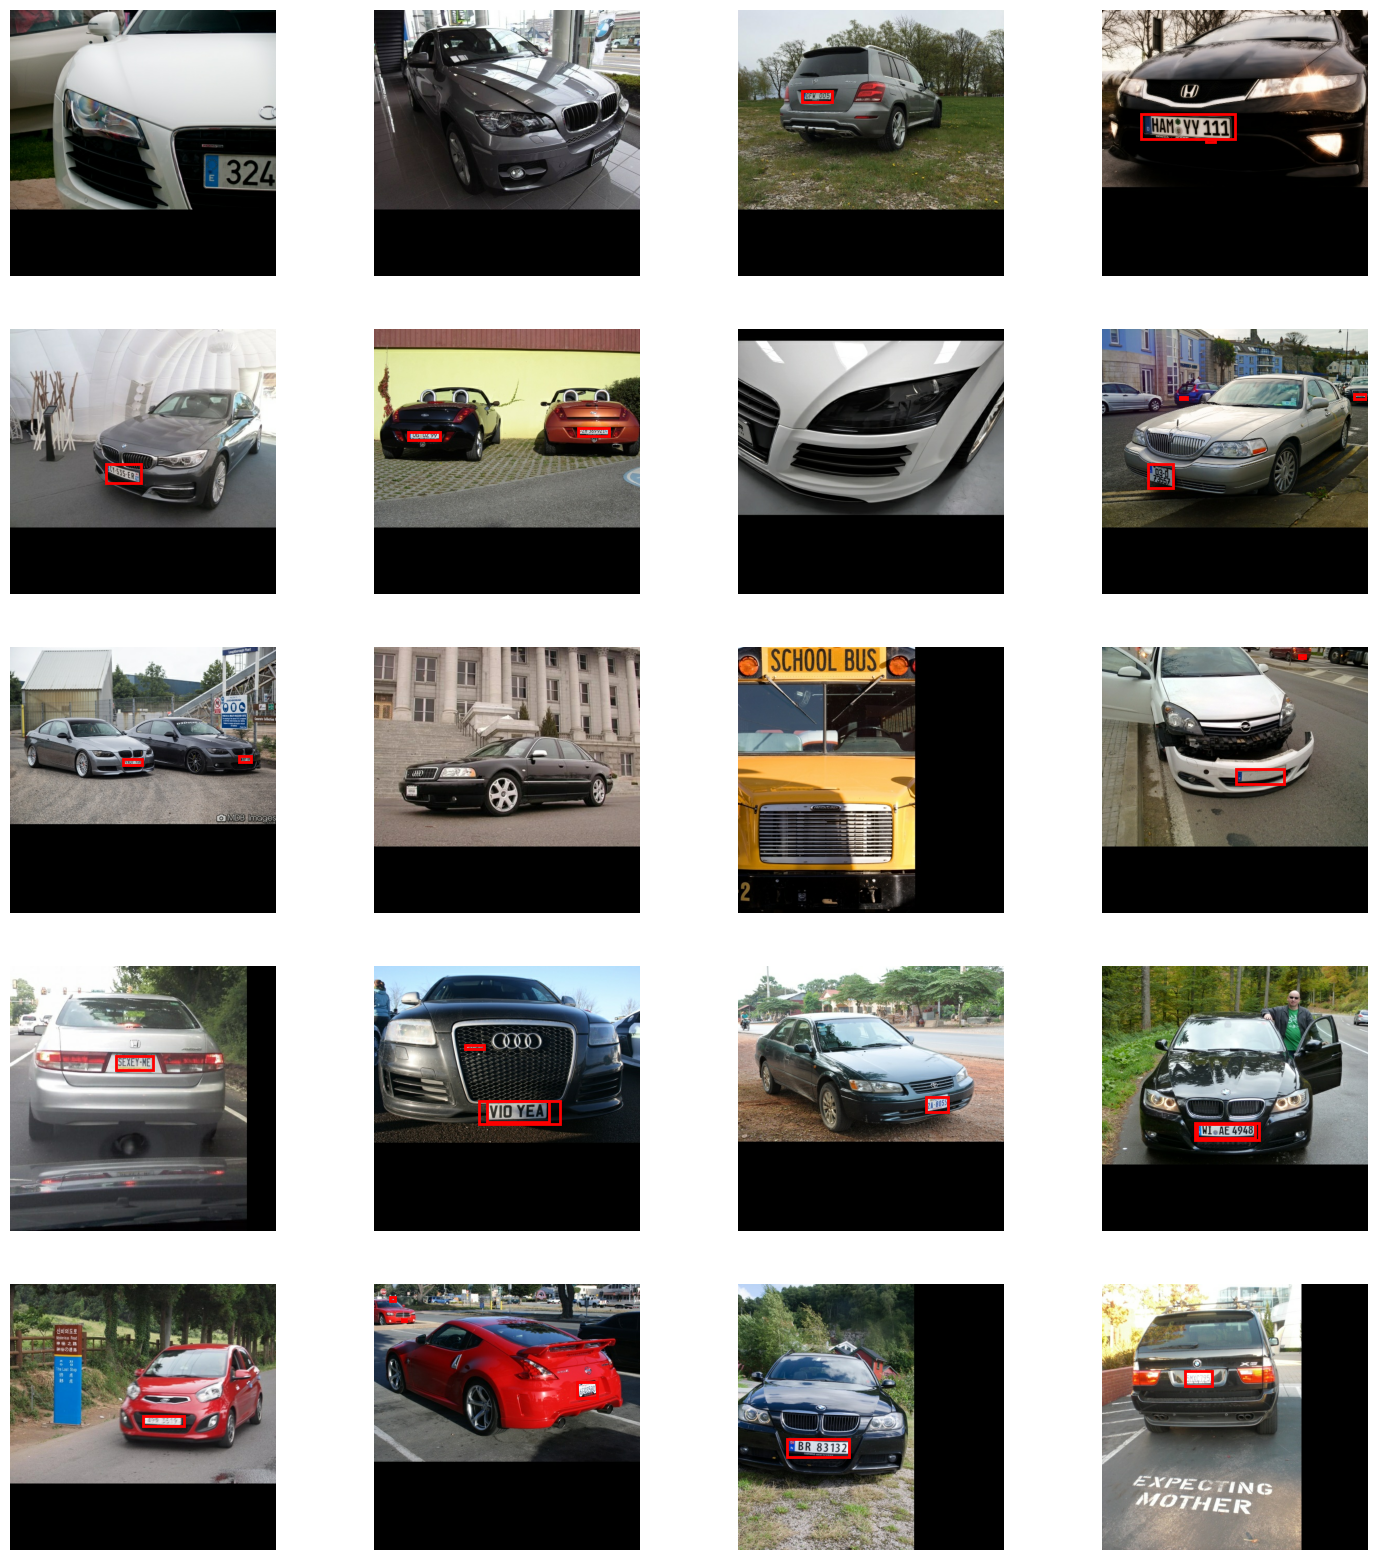

In [16]:
plot_images_with_y_preds(test_x/255,test_y_pred,["Plate"],image_per_row=4,show_labels=False)

In [27]:
carla_image = cv2.imread("carla_images/image.png")

_, carla_image_resized = resize_image(carla_image)
pred = yolov8_plates_detector.predict(np.array([carla_image_resized]))
#_, carla_image_resized = resize_image(carla_image)
#print(carla_image_resized.shape)
#cv2.imshow("Carla Image", carla_image_resized)
#cv2.waitKey(0)
#cv2.destroyAllWindows()


1/1 [==============================] - 0s 354ms/step


In [28]:
#print(pred["boxes"][0])
#box = pred["boxes"][0][0]
for box in pred["boxes"][0]:
    if box[0] == -1:
        break
    cv2.rectangle(carla_image_resized, (int(box[0]), int(box[1])), (int(box[0] + box[2]), int(box[1] + box[3])), (0, 255, 0), 1)
cv2.imshow("Carla Image", carla_image_resized)
cv2.waitKey(0)
cv2.destroyAllWindows()


Looking for C:\Users\claudio.verazza\.keras-ocr\craft_mlt_25k.h5


ValueError: Unrecognized keyword arguments passed to Dense: {'weights': [array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32), array([1., 0., 0., 0., 1., 0.], dtype=float32)]}